## ARCH:
### Automatised analysis of Searchlight accuracy maps at the group level.
#### Group level analysis is performing one-sample ttest (with smoothing=3) with FDR correction. 
#### The script is producing the z score files in .npy and .nii format.
##### Opt. visualise the map interactively or in static.
##### Searchlight analysis was performed using rsa method with py-rsatoolbox.
https://rsatoolbox.readthedocs.io/en/latest/
##### Second-level analysis performed in NILEARN 
https://nilearn.github.io/stable/index.html

#### packages needed to run it: 

- nilearn 0.8.1
- nibabel 3.2.1
- numpy  1.21.4
- matplotlib 3.5.0
- scipy 1.7.3
- pandas 1.3.4
- seaborn 0.11.2
- tabulate (to print the cluster table)

###### Created 10/12/2021 IMS: sztuka@gmail.com
###### Adapted 12/04/2022

In [1]:
#!/usr/bin/python3
# ARCH-RSA searchlight second-level post rsa-method wholebrain searchlight.
from nilearn import datasets
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import image
from nilearn import plotting
from nilearn import masking
from nilearn.reporting import get_clusters_table
from glob import glob
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from nilearn.image import get_data, math_img
from scipy.stats import norm
import seaborn as sns

/opt/anaconda3/envs/TR/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/opt/anaconda3/envs/TR/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
#where you save the resulting z-score
grouplevel_z = 'Path_to/Group_Level/z_score/'

### Run next two cells to produce npy & nii for each model

In [3]:
# Set parameters:
#name of the model in dir and file name
# model name
model_name = 'AN'
# if filename is different
another_name = model_name
# should be 34 all through.
n_samples = 34
print(model_name)

AN


### For all models perform second-level analysis
#### applies to all models except for dCNNs!

In [19]:
# load the subject-level .nii accuracy maps
n_subjects=n_samples
src = '/Path_to/'+model_name+'/Results/ARCH_SL_'+another_name+'_result_sub-*.nii.gz'
# Load the accuracy maps from searchlight. 
data_folder =  src
cmap_filenames = list(glob(f"{data_folder}"))
cmap_filenames.sort()
tmp_img = nib.load(cmap_filenames[0])
affine_mat = tmp_img.affine
dimsize = tmp_img.header.get_zooms()
# Construct design matrix & model
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])
# Added smoothing parameter = 3
second_level_model = SecondLevelModel(smoothing_fwhm=3.0).fit(cmap_filenames, design_matrix=design_matrix)
#Estimate model
# output_type must be one of ['z_score', 'stat', 'p_value', 'effect_size', 'effect_variance', 'all']
z_map = second_level_model.compute_contrast(second_level_stat_type='t',output_type='z_score')
# save z_maps 
file_nb = 'ARCH_'+model_name+'_z_score.npy'
file_csv = 'ARCH_'+model_name+'_z_score.nii'
file_nbFigures = os.path.join(grouplevel_z, file_nb)
np.save(file_nbFigures,z_map)
sl_result = z_map 
sl_nii = nib.Nifti1Image(sl_result, affine_mat)  # create the volume image
hdr = sl_nii.header  # get a handle of the .nii file's header
output_dir = os.path.join(grouplevel_z, file_csv)
nib.save(sl_result, output_dir)  # Save the volume
print(model_name+' done deal!')

Rating3 done deal!


### Plot the uncorrected values: 

In [ ]:
display = plotting.plot_stat_map(z_map, title='Raw z map')

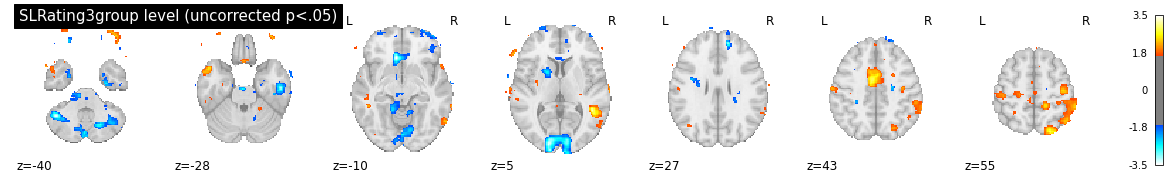

In [20]:
# threshold the second level contrast at uncorrected p < 0.05 and plot it.
p_val = 0.05
p001_unc = norm.isf(p_val)
display = plotting.plot_stat_map(
    z_map, threshold=p001_unc, colorbar=True, display_mode='z',
    title='SL'+model_name+'group level (uncorrected at p<.05)')
# plot the results:
plotting.show()

### Plot results of FDR correction: 

Function **threshold_stats_img** computes the required threshold level and returns the thresholded map. 

<p>Parameters:
<p>alpha = Number controlling the thresholding (either a p-value or q-value). Its actual meaning depends on the height_control parameter. This function translates alpha to a z-scale threshold. Default alpha=0.001.
<p>height_control= False positive control meaning of cluster forming threshold: None|’fpr’|’fdr’|’bonferroni’ Default=’fpr’.
<p>cluster_threshold = (optional) cluster size threshold. In the returned thresholded map, sets of connected voxels (clusters) with size smaller than this number will be removed. Default=0.
<p>two_sided = (optional) Whether the thresholding should yield both positive and negative part of the maps. In that case, alpha is corrected by a factor of 2. Default=True.


In [2]:
#Compute the fdr-corrected p = 0.05 threshold with no cluster-level threshold
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr', two_sided=False)
print('The FDR=.05 threshold is %.3g' % threshold2)
plotting.plot_stat_map(thresholded_map2, symmetric_cbar=True, cut_coords=display.cut_coords,
                       title='Group-level '+model_name+' Thresholded z map, expected fdr = .05',
                       threshold=threshold2)
plotting.show()

NameError: name 'threshold_stats_img' is not defined

In [16]:
# Display cluster table with cluster threshold of > 10 voxels. 
print(get_clusters_table(z_map, threshold2, cluster_threshold=10).to_markdown()) 

|    | Cluster ID   |     X |     Y |     Z |   Peak Stat | Cluster Size (mm3)   |
|---:|:-------------|------:|------:|------:|------------:|:---------------------|
|  0 | 1            |  -8.5 | -80.5 |  -2.5 |     7.44064 | 100264               |
|  1 | 1a           |   7.5 | -94.5 |  -2.5 |     6.66464 |                      |
|  2 | 1b           |  11.5 | -68.5 |  17.5 |     4.27708 |                      |
|  3 | 1c           |  17.5 | -86.5 | -22.5 |     4.15789 |                      |
|  4 | 2            | -38.5 | -80.5 |  23.5 |     3.09889 | 48                   |


### Plot the FDR results interactively: 
<p> 

In [22]:
# create the view
view = plotting.view_img(thresholded_map2, colorbar=True,
    title='Group-level '+model_name+layer+' (fdr=0.05)')
# view in the cell below
#view
# view in the browser
view.open_in_browser()

### FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold. 

<p> As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

In [ ]:
thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni',two_sided=False)
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)
plotting.plot_stat_map(thresholded_map3, symmetric_cbar=True, cut_coords=display.cut_coords,
                       title='Group-level '+model_name+' Thresholded z map, expected fwer < .05',
                       threshold=threshold3)

In [ ]:
# Display cluster table. 
print(get_clusters_table(z_map, threshold3).to_markdown()) 

### Plot the FWER results interactively: 

In [ ]:
# create the view
view = plotting.view_img(thresholded_map3, colorbar=True,
    title='Group-level '+model_name+layer+' (fwer=0.05)')
# view in the cell below
#view
# view in the browser
view.open_in_browser()